# Variational Quantum Eigensolver - Ground State Energy for $H2$ Molecule using the UCCSD ansatz

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock, UCCSD, PUCCD

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [5]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for $H2$ molecule at equilibrium bond length 0.735 Angstrom

In [6]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [7]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [8]:
def initial_state_preparation(dist: float, mapper_str: str = "pa"):
    
    molecule = "H 0.0 0.0 0.0; H 0.0 0.0 " + str(dist)
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [9]:
inter_atomic_dists: list = np.arange(0.4, 2.0, 0.05)

In [32]:
numpy_eigensolver_electronic_ground_energies: list = []
numpy_eigensolver_nuclear_repulsion_energies: list = []
numpy_eigensolver_total_ground_state_energies: list = []

from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

print("Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    # construct NumPyEigensolver - solver algorithm
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    # calculate excited states using the NumPyEigensolver solver algorithm
    numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
    # Compute Ground and Excited States properties.
    numpy_ground_excited_states_properties = numpy_excited_states_calculation.solve(es_problem)
    
    # Get Repulsion energy from properties of ground and excited states
    nuclear_repulsion_energy = numpy_ground_excited_states_properties.nuclear_repulsion_energy
    numpy_eigensolver_nuclear_repulsion_energies.append(nuclear_repulsion_energy)
    
    # constructs NumPyMinimumEigensolver - solver algorithm
    numpy_minimum_solver = NumPyMinimumEigensolverFactory()
    # compute the ground state using a minimum eigensolver
    numpy_ground_state_calculation = GroundStateEigensolver(qubit_converter, numpy_minimum_solver)
    # Compute Ground state properties - returns an Eigenstate result
    numpy_ground_state_properties = numpy_ground_state_calculation.solve(es_problem)
    
    # Get electronic ground state energies
    electronic_ground_energy = np.real(numpy_ground_state_properties.eigenenergies[0])
    numpy_eigensolver_electronic_ground_energies.append(electronic_ground_energy)
    
    # Get the total ground state energy
    total_ground_state_energy = (electronic_ground_energy + nuclear_repulsion_energy)
    numpy_eigensolver_total_ground_state_energies.append(total_ground_state_energy)
    
    print("Interatomic dist: {:.4f} Å \t Electronic Ground Energy: {:.4f} Eh \tTotal Ground State Energy: {:.4f} Eh".format(dist, electronic_ground_energy, total_ground_state_energy))
    # print("Interatomic dist: {:.4f} Å \t Total Ground State Energy: {:.4f} Eh".format(dist, total_ground_state_energy))
    

Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm

Interatomic dist: 0.4000 Å 	 Electronic Ground Energy: -2.2371 Eh 	Total Ground State Energy: -0.9141 Eh
Interatomic dist: 0.4500 Å 	 Electronic Ground Energy: -2.1744 Eh 	Total Ground State Energy: -0.9984 Eh
Interatomic dist: 0.5000 Å 	 Electronic Ground Energy: -2.1135 Eh 	Total Ground State Energy: -1.0552 Eh
Interatomic dist: 0.5500 Å 	 Electronic Ground Energy: -2.0548 Eh 	Total Ground State Energy: -1.0926 Eh
Interatomic dist: 0.6000 Å 	 Electronic Ground Energy: -1.9982 Eh 	Total Ground State Energy: -1.1163 Eh
Interatomic dist: 0.6500 Å 	 Electronic Ground Energy: -1.9440 Eh 	Total Ground State Energy: -1.1299 Eh
Interatomic dist: 0.7000 Å 	 Electronic Ground Energy: -1.8922 Eh 	Total Ground State Energy: -1.1362 Eh
Interatomic dist: 0.7500 Å 	 Electronic Ground Energy: -1.8427 Eh 	Total Ground State Energy: -1.1371 Eh
Interatomic dist: 0.8000 Å 	 Electronic Ground Energy: -1.7956 Eh 	Total Gro

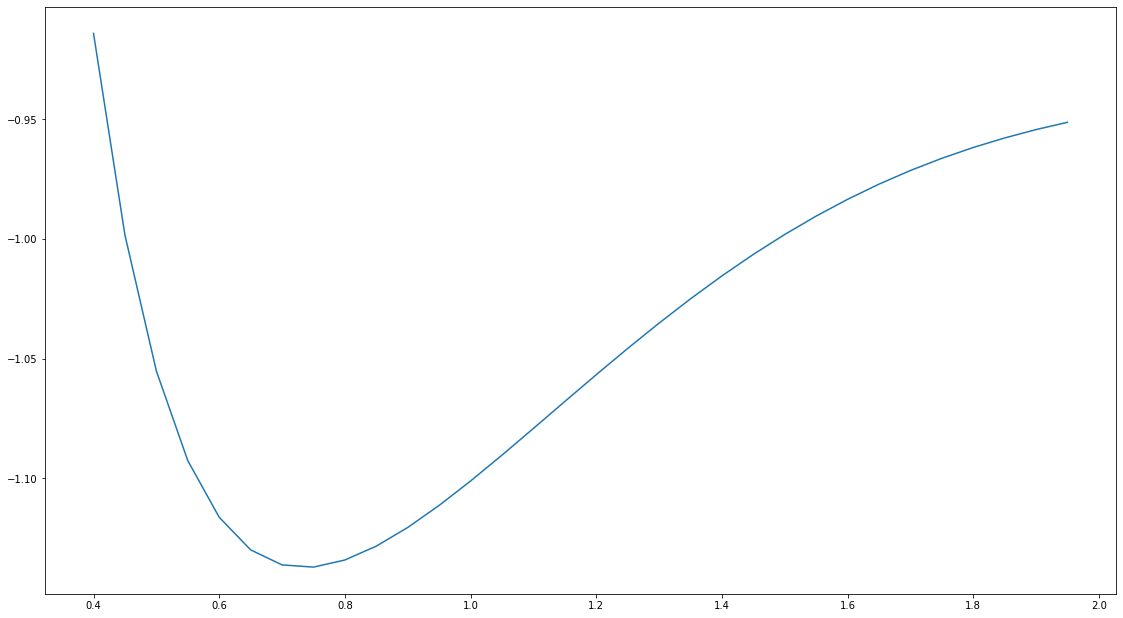

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies)
plt.show()

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275016725
  - computed part:      -1.857275016725
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306022276
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38881261]
    - computed part:      [0.0  0.0  1.38881261]
  > Dipole moment (a.u.): [0.0  0.0  0.00013609]  Total: 0.00013609
                 (debye): [0.0  0.0  0.0003459]  Total: 0.0003459
 


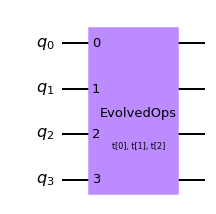

In [10]:
uccsd_total_ground_state_energies: list = []

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

ansatz = 0
backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend=state_sim)#Aer.get_backend("aer_simulator_statevector"))
optimizer = COBYLA(maxiter=10000)

for dist in inter_atomic_dists:
# dist = 0.735
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "jw")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    ansatz_type = "UCCSD"

    ansatz = UCCSD(
        qubit_converter=qubit_converter,
        num_particles=num_particles,
        num_spin_orbitals=num_spin_orbitals,
        reps=1,
        initial_state=init_state,
    )

    ansatz.compose(init_state, front=True, inplace=True)

    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    vqe_solver = VQEUCCFactory(
        quantum_instance=quantum_instance,
        optimizer=optimizer,
        initial_point=initial_point,
        ansatz=ansatz,
        initial_state=init_state,
        callback=callback
    )

    # result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    result = calc.solve(es_problem)
    uccsd_total_ground_state_energies.append( result.total_energies[0] )
    print(result)

ansatz.draw("mpl")

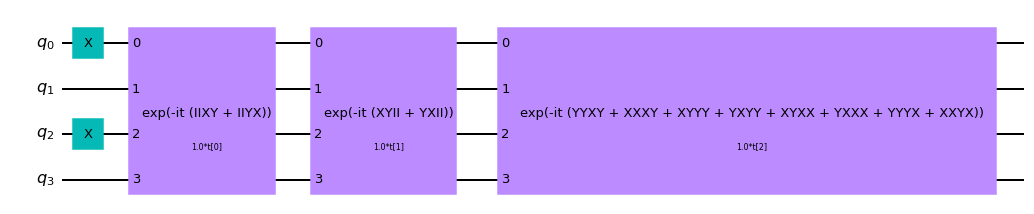

In [14]:
ansatz.decompose().draw("mpl")

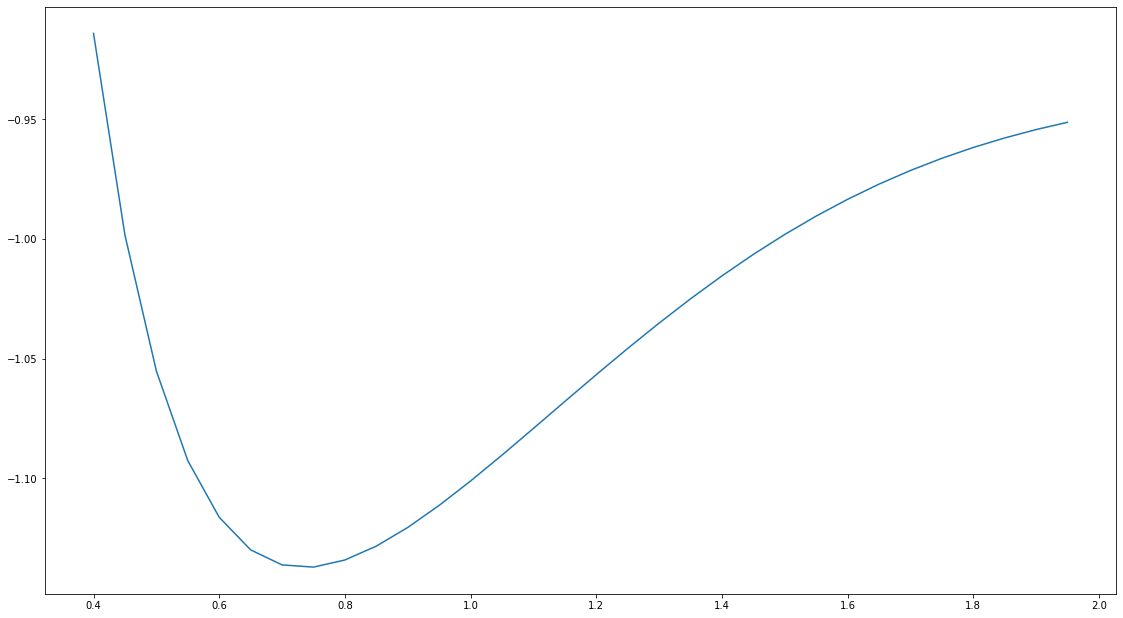

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
plt.plot(inter_atomic_dists, uccsd_total_ground_state_energies)
plt.show()

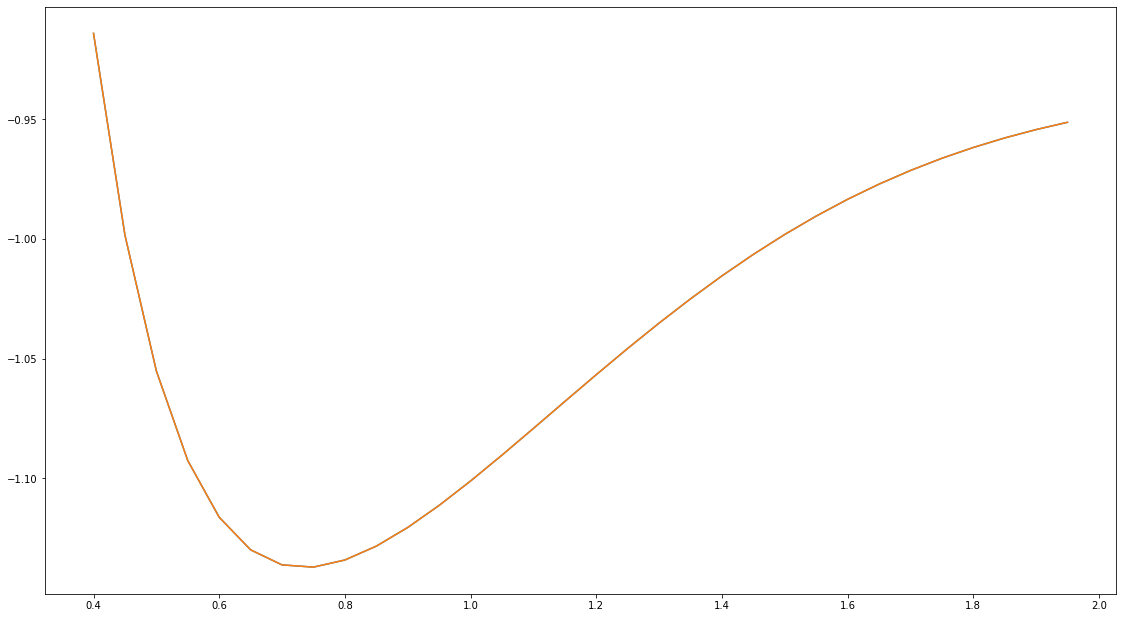

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies)
plt.plot(inter_atomic_dists, uccsd_total_ground_state_energies)
plt.show()